In [3]:
from astropy.table import Table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import simulation
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.trainers.base import infer
#import corner
import pickle
import itertools

Constrain cosmology with KiDs clusters

| z range      | zeff            | λ* range  | λ*eff           | log [M200/(10^14 M h−1)] | Ncl  | zs,eff          |
|--------------|-----------------|-----------|-----------------|--------------------------|------|-----------------|
| [0.10, 0.30] | 0.189 ± 0.001    | [0, 15]   | 10.20 ± 0.09    | -0.73 ± 0.07             | 1246 | 0.849 ± 0.002   |
| [0.10, 0.30] | 0.212 ± 0.002    | [15, 25]  | 18.88 ± 0.12    | -0.38 ± 0.07             | 684  | 0.867 ± 0.002   |
| [0.10, 0.30] | 0.222 ± 0.004    | [25, 35]  | 29.02 ± 0.21    | 0.05 ± 0.07              | 209  | 0.879 ± 0.002   |
| [0.10, 0.30] | 0.228 ± 0.007    | [35, 45]  | 39.75 ± 0.32    | 0.32 ± 0.06              | 82   | 0.877 ± 0.005   |
| [0.10, 0.30] | 0.222 ± 0.008    | [45, 150] | 56.59 ± 2.20    | 0.54 ± 0.06              | 44   | 0.890 ± 0.013   |
| [0.30, 0.45] | 0.374 ± 0.001    | [0, 20]   | 15.10 ± 0.11    | -0.41 ± 0.08             | 1113 | 0.948 ± 0.003   |
| [0.30, 0.45] | 0.387 ± 0.002    | [20, 30]  | 24.08 ± 0.11    | -0.07 ± 0.07             | 767  | 0.944 ± 0.004   |
| [0.30, 0.45] | 0.389 ± 0.002    | [30, 45]  | 35.91 ± 0.27    | 0.21 ± 0.06              | 320  | 0.941 ± 0.005   |
| [0.30, 0.45] | 0.390 ± 0.005    | [45, 60]  | 50.88 ± 0.50    | 0.41 ± 0.08              | 87   | 0.950 ± 0.015   |
| [0.30, 0.45] | 0.379 ± 0.006    | [60, 150] | 73.60 ± 2.09    | 0.68 ± 0.07              | 45   | 0.946 ± 0.012   |
| [0.45, 0.60] | 0.498 ± 0.001    | [0, 25]   | 19.71 ± 0.11    | -0.33 ± 0.09             | 1108 | 0.958 ± 0.001   |
| [0.45, 0.60] | 0.514 ± 0.002    | [25, 35]  | 29.23 ± 0.12    | -0.07 ± 0.07             | 761  | 0.961 ± 0.004   |
| [0.45, 0.60] | 0.523 ± 0.003    | [35, 45]  | 39.25 ± 0.18    | 0.21 ± 0.07              | 299  | 0.961 ± 0.006   |
| [0.45, 0.60] | 0.513 ± 0.004    | [45, 150] | 55.12 ± 0.76    | 0.36 ± 0.07              | 197  | 0.960 ± 0.004   |


- Need to add a redshift evolution of the mass-observable scaling relation
- Correct for the incompleteness
    - Not like they do...
    
    

In [2]:
kids_lambda_bins = [ [ 0 , 15 , 25 , 35 , 45, 150 ], 
                     [ 0 , 20 , 30 , 45 , 60 , 150 ] ,
                     [ 0 , 25 , 35 , 45 , 150 ] ]

kids_z_bins = [ 0.10 , 0.30 , 0.45 , 0.60 ]

mwl_mean_0 = np.array( [ 14-0.73 , 14-0.38 , 14+0.05 , 14+0.32 , 14+0.54 ] )
mwl_mean_1 = np.array( [ 14-0.41 , 14-0.07, 14+0.21 , 14+0.41, 14+0.68 ] )
mwl_mean_2 = np.array( [ 14-0.33, 14-0.07, 14+0.21, 14+0.36 ] )

mwl_std_0 = np.array( [ 0.07 , 0.07 , 0.07 , 0.06 , 0.06 ] )
mwl_std_1 = np.array( [ 0.08 , 0.07 , 0.06 , 0.08 , 0.07 ] )
mwl_std_2 = np.array( [ 0.09 , 0.07 , 0.07 , 0.07 ] )

mwl_std = [ [ 0.07 , 0.07 , 0.07 , 0.06 , 0.06 ] ,
            [ 0.08 , 0.07 , 0.06 , 0.08 , 0.07 ] ,
            [ 0.09 , 0.07 , 0.07 , 0.07 ] ]

# # these are just for mass measurements...
# rich_bins_0 = np.array( [ 0 , 15 , 25 , 35 , 45 , 150 ] )
# rich_bins_1 = np.array( [ 0 , 20 , 20 , 30 , 45 , 60, 150 ] )
# rich_bins_2 = np.array( [ 0 , 25 , 35 , 45 , 150 ] )

# rich_cents_0 = np.array([ 10.2 , 18.88 , 29.9 , 39.75 , 56.59 ])
# rich_cents_1 = np.array([ 15.1 , 24.08 , 35.91 , 50.88 , 73.6  ])
# rich_cents_2 = np.array([ 19.71 , 29.23 , 39.25 , 55.12 ])

# n_clusters_0 = np.array( [ 1246 , 684 , 209, 82 , 44 ])
# n_clusters_1 = np.array( [ 1113, 767 , 320 , 87 , 45  ])
# n_clusters_2 = np.array( [ 1108 , 761 , 299 , 197  ])

In [3]:
wl_kids_lambda_bins = [ [ 15 , 25 , 35 , 45, 150 ], 
                     [ 20 , 30 , 45 , 60 , 150 ] ,
                     [ 25 , 35 , 45 , 150 ] ]

kids_z_bins = [ 0.10 , 0.30 , 0.45 , 0.60 ]

mwl_mean_0 = np.array( [ 14-0.38 , 14+0.05 , 14+0.32 , 14+0.54 ] )
mwl_mean_1 = np.array( [ 14-0.07, 14+0.21 , 14+0.41, 14+0.68 ] )
mwl_mean_2 = np.array( [ 14-0.07, 14+0.21, 14+0.36 ] )

mwl_std = [ [ 0.07 , 0.07 , 0.06 , 0.06 ] ,
            [ 0.07 , 0.06 , 0.08 , 0.07 ] ,
            [ 0.07 , 0.07 , 0.07 ] ]

mwl_std_0 = np.array( [ 0.07 , 0.07 , 0.06 , 0.06 ] )
mwl_std_1 = np.array( [ 0.07 , 0.06 , 0.08 , 0.07 ] )
mwl_std_2 = np.array( [ 0.07 , 0.07 , 0.07 ] )

rich_bins_0 = np.array( [ 15 , 25 , 35 , 45 , 1500 ] )
rich_bins_1 = np.array( [ 20 , 20 , 30 , 45 , 60, 1500 ] )
rich_bins_2 = np.array( [ 25 , 35 , 45 , 1500 ] )

rich_cents_0 = np.array([ 18.88 , 29.9 , 39.75 , 56.59 ])
rich_cents_1 = np.array([ 24.08 , 35.91 , 50.88 , 73.6  ])
rich_cents_2 = np.array([ 29.23 , 39.25 , 55.12 ])

wl_rich_cents = [ rich_cents_0 , rich_cents_1 , rich_cents_2 ]

# n_clusters_0 = np.array( [ 684 , 209, 82 , 44 ])
# n_clusters_1 = np.array( [ 767 , 320 , 87 , 45  ])
# n_clusters_2 = np.array( [ 761 , 299 , 197  ])

With regard to the binning in intrinsic richness, we adopt 4 logarithmically spaced bins in the range λ∗ ∈ [20, 137]

In [4]:
kids_lambda_bins = np.logspace( np.log10( 20 ) , np.log10( 137 ) , 5 )
rich_cents = [ 25 , 41 , 66 , 108 ]

n_clusters_0 = np.array( [ 414 , 141 , 20 , 3 ])
n_clusters_1 = np.array( [ 850 , 290 , 69 , 11  ])
n_clusters_2 = np.array( [ 1216 , 555 , 95, 8  ])

(13.0, 15.0)

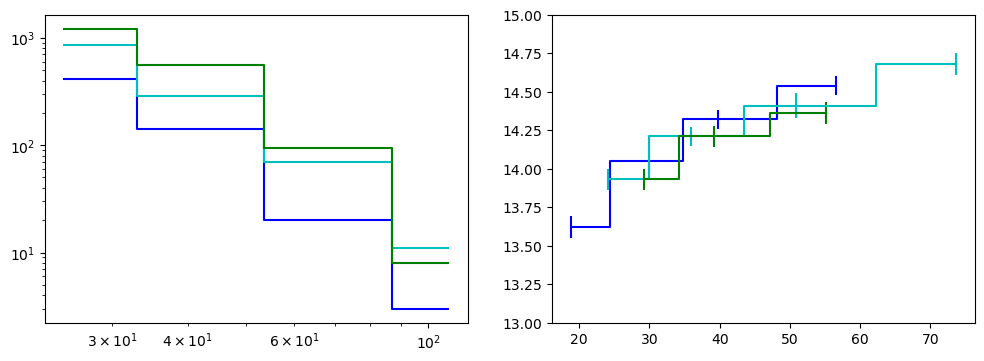

In [5]:
plt.figure( figsize = ( 12, 4 ))
plt.subplot(121)
plt.plot( rich_cents , n_clusters_0 , drawstyle='steps-mid' , color = 'b')
plt.plot( rich_cents , n_clusters_1 , drawstyle='steps-mid' , color = 'c')
plt.plot( rich_cents , n_clusters_2 , drawstyle='steps-mid' , color = 'g')
plt.xscale('log')
plt.yscale('log')

plt.subplot(122)
plt.errorbar( rich_cents_0 , mwl_mean_0 , yerr = mwl_std_0, fmt='b-' , drawstyle = 'steps-mid')
plt.errorbar( rich_cents_1 , mwl_mean_1 , yerr = mwl_std_1, fmt='c-' , drawstyle = 'steps-mid')
plt.errorbar( rich_cents_2 , mwl_mean_2 , yerr = mwl_std_2, fmt='g-' , drawstyle = 'steps-mid')
plt.ylim( 13. , 15 )

In [6]:
z_bins_sel = np.array([ 0.1 , 0.3 , 0.45 , 0.6 ] )
l_bins_sel = np.array( [ 10 , 15 , 20 , 25 , 30 , 35 , 40 , 45 , 1000 ])

In [7]:
selection_function = np.array( [ [ 71 , 87 , 92 , 100 , 100 , 100 , 100 , 100 ],
                                 [ 50 , 78 , 90 , 95 , 100 , 100 , 95 , 100 ],
                                 [ 33 , 58 , 81 , 90 , 96 , 95 , 95 , 100 ] ])/100

(0.0, 1.1)

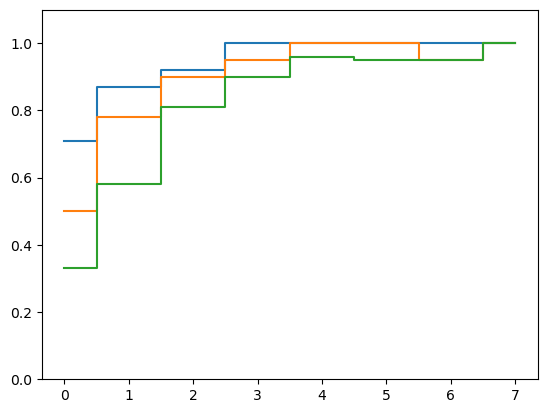

In [8]:
plt.figure()
plt.plot( selection_function[0] , drawstyle='steps-mid')
plt.plot( selection_function[1] , drawstyle='steps-mid')
plt.plot( selection_function[2] , drawstyle='steps-mid')
plt.ylim( 0 , 1.1 )

In [9]:
n_clusters_lol = [ n_clusters_0 , n_clusters_1 , n_clusters_2 ]
mwl_mean_lol = [ mwl_mean_0 , mwl_mean_1 , mwl_mean_2 ]

In [10]:
kids_lambda_bins

array([ 20.        ,  32.35583697,  52.34500931,  84.68332939,
       137.        ])

In [161]:
stacked_simulator = simulation.Universe_simulation( 'stacked_counts_wonky_bins' ,
                                                    variable_params=['omega_m', 'sigma_8', 'alpha' , 'c' , 'sigma' , 'r' , 'beta' ],
                                                    fixed_params={'w_0': -1, 'w_a': 0 } )

stacked_simulator.dOmega = 377/41253 * 4*np.pi
stacked_simulator.z_bins = np.arange( 0.1 , 0.6 , 0.05 )
stacked_simulator.sigma_mwl = 0.3
stacked_simulator.log10ms = np.arange( 13., 15.5, stacked_simulator.dlog10m )
stacked_simulator.include_mwl_measurement_errors = True
stacked_simulator.mwl_std = mwl_std

# bins for counts
stacked_simulator.richness_bins = kids_lambda_bins
stacked_simulator.redshift_bins = kids_z_bins
# bins for masses
stacked_simulator.wl_richness_bins = wl_kids_lambda_bins
stacked_simulator.wl_redshift_bins = kids_z_bins

# I have no idea what the KiDs people actually do
stacked_simulator.selection_richness = 0

# add the selection function
stacked_simulator.use_selection_function = True
stacked_simulator.selection_function = selection_function
stacked_simulator.z_bins_sel = z_bins_sel
stacked_simulator.l_bins_sel = np.log( l_bins_sel )

In [162]:
stacked_simulator_no_r = simulation.Universe_simulation( 'stacked_counts_wonky_bins' ,
                                                    variable_params=['omega_m', 'sigma_8', 'alpha' , 'c' , 'sigma' , 'beta' ],
                                                    fixed_params={'w_0': -1, 'w_a': 0 } )

stacked_simulator_no_r.dOmega = 377/41253 * 4*np.pi
stacked_simulator_no_r.richness_bins = kids_lambda_bins
stacked_simulator_no_r.redshift_bins = kids_z_bins
stacked_simulator_no_r.z_bins = np.arange( 0.1 , 0.6 , 0.05 )
stacked_simulator_no_r.sigma_mwl = 0.3
stacked_simulator_no_r.log10ms = np.arange( 13., 15.5, stacked_simulator.dlog10m )
stacked_simulator_no_r.include_mwl_measurement_errors = True
stacked_simulator_no_r.mwl_std = mwl_std

# bins for counts
stacked_simulator_no_r.richness_bins = kids_lambda_bins
stacked_simulator_no_r.redshift_bins = kids_z_bins
# bins for masses
stacked_simulator_no_r.wl_richness_bins = wl_kids_lambda_bins
stacked_simulator_no_r.wl_redshift_bins = kids_z_bins

# I have no idea what the KiDs people actually do
stacked_simulator_no_r.selection_richness = 0

# add the selection function
stacked_simulator_no_r.use_selection_function = True
stacked_simulator_no_r.selection_function = selection_function
stacked_simulator_no_r.z_bins_sel = z_bins_sel
stacked_simulator_no_r.l_bins_sel = np.log( l_bins_sel )

In [50]:
mean_params

[0.15583330392837524,
 1.2575247287750244,
 1.1485737562179565,
 3.2269463539123535,
 0.18732237815856934,
 0.47633519768714905,
 -0.8047333061695099]

In [175]:
mean_params

[0.14710873365402222,
 0.8347938358783722,
 0.6665107607841492,
 3.2426873445510864,
 0.19433949142694473,
 1.0799531936645508]

In [197]:
sim_obs = stacked_simulator.run_simulation( torch.Tensor( [ 0.3 , 0.83 , 0.67 , 3.2 , 0.2 , 0 , 1 ] )  )

In [198]:
sim_obs

array([ 783.        , 1784.        , 2505.        ,  300.        ,
        663.        , 1038.        ,   98.        ,  197.        ,
        290.        ,   18.        ,   47.        ,   62.        ,
         13.87194329,   14.05311075,   14.26003666,   14.53865684,
         14.00833104,   14.11419218,   14.51559809,   14.56164218,
         13.93589861,   14.14862287,   14.5099602 ])

In [199]:
len(sim_obs)

23

In [200]:
def reconstruct_lists_of_lists(flattened_array, sublist_lengths):
    """
    Reconstructs a list of lists from a flattened array based on the sublist lengths.

    Parameters:
    - flattened_array (array-like): The flattened array to be reconstructed.
    - sublist_lengths (list): A list containing the lengths of each sublist.

    Returns:
    - list of lists reconstructed from the flattened array.
    """
    reconstructed_list = []
    index = 0
    for length in sublist_lengths:
        sublist = flattened_array[index:index + length]
        reconstructed_list.append(sublist)
        index += length
    return reconstructed_list

# FIX THIS WITH THE NEW SETUP

# Example usage:
# Suppose you know the sublist lengths from your original bins
sublist_lengths = [len( kids_lambda_bins ) - 1 for idx_bin in range(len(kids_z_bins) - 1)]

# Reconstruct lists of lists
sim_counts = sim_obs[:12].reshape( 4 , 3 ).T
sim_mwl_mean = ( reconstruct_lists_of_lists( sim_obs[12:] , sublist_lengths) )


In [211]:
log10ms = np.linspace( 13 , 15.5 , 10 )
mus = np.log( 10 ** log10ms / 1e14 )

In [215]:
r_0

0.052115337828390236

In [216]:
c_0

-0.07999999999999999

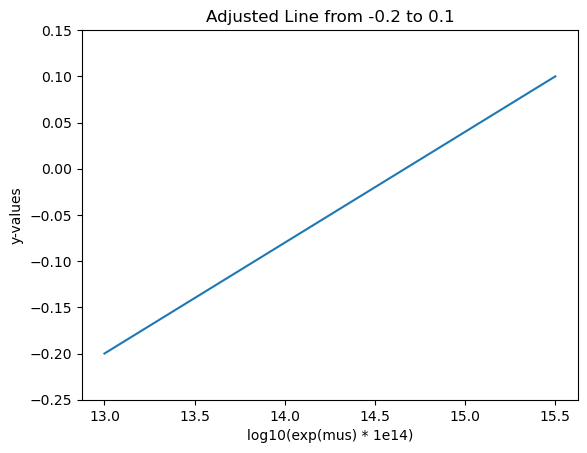

In [214]:
# Define the desired range for the line
y_min = -0.2
y_max = 0.1

# Adjust the slope (r_0) and intercept (c_0) to match the desired range
r_0 = (y_max - y_min) / (mus.max() - mus.min())  # Slope calculation
c_0 = y_min - r_0 * mus.min()  # Intercept calculation

# Plot the line
plt.figure()
plt.plot( np.log10(np.exp(mus) * 1e14), r_0 * mus + c_0)
plt.ylim(-0.25, 0.15)  # Adjusting y-limits for better visualization
plt.xlabel('log10(exp(mus) * 1e14)')
plt.ylabel('y-values')
plt.title('Adjusted Line from -0.2 to 0.1')
plt.show()

In [201]:
kids_observations

test_counts = kids_observations[:12].reshape( 4 , 3 ).T
test_mwl_mean = ( reconstruct_lists_of_lists( kids_observations[12:] , sublist_lengths) )

In [202]:
test_counts

array([[ 414.,  141.,   20.,    3.],
       [ 850.,  290.,   69.,   11.],
       [1216.,  555.,   95.,    8.]])

In [203]:
test_counts - np.array( [ n_clusters_0 , n_clusters_1 , n_clusters_2 ])

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [204]:
test_mwl_mean

[array([13.62, 14.05, 14.32, 14.54]),
 array([13.93, 14.21, 14.41, 14.68]),
 array([13.93, 14.21, 14.36])]

In [205]:
mwl_mean_flat

array([13.62, 14.05, 14.32, 14.54, 13.93, 14.21, 14.41, 14.68, 13.93,
       14.21, 14.36])

(13.0, 15.0)

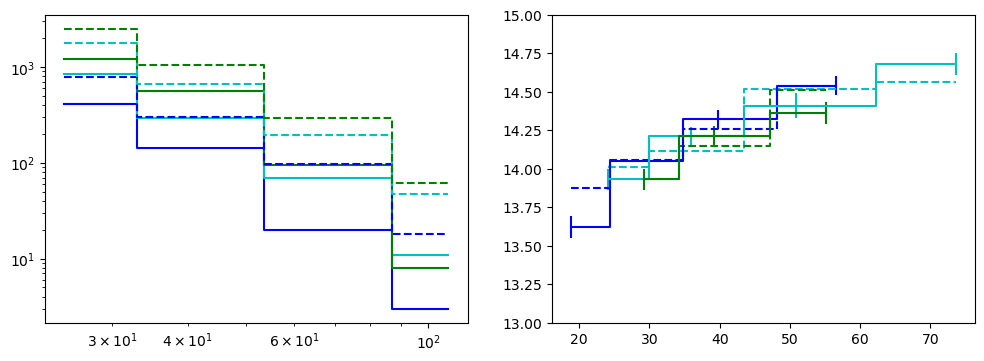

In [206]:
plt.figure( figsize = ( 12, 4 ))
plt.subplot(121)
plt.plot( rich_cents , n_clusters_0 , drawstyle='steps-mid' , color = 'b')
plt.plot( rich_cents , n_clusters_1 , drawstyle='steps-mid' , color = 'c')
plt.plot( rich_cents , n_clusters_2 , drawstyle='steps-mid' , color = 'g')

colors = [ 'b' , 'c' , 'g' ]

i = 0
for counts in sim_counts:
    plt.plot( rich_cents , counts , '--' , color = colors[i], drawstyle = 'steps-mid')
    i += 1
    
plt.xscale('log')
plt.yscale('log')

plt.subplot(122)
plt.errorbar( rich_cents_0 , mwl_mean_0 , yerr = mwl_std_0, fmt='b-' , drawstyle = 'steps-mid')
plt.errorbar( rich_cents_1 , mwl_mean_1 , yerr = mwl_std_1, fmt='c-' , drawstyle = 'steps-mid')
plt.errorbar( rich_cents_2 , mwl_mean_2 , yerr = mwl_std_2, fmt='g-' , drawstyle = 'steps-mid')

i = 0
for mwl_mean in sim_mwl_mean:
    plt.plot( wl_rich_cents[i] , mwl_mean , '--'  , color = colors[i] , drawstyle = 'steps-mid')
    i += 1
    
plt.ylim( 13. , 15 )

In [124]:
prior = utils.BoxUniform( low = [ 0.05 , 0.4  , 0 , 1 , 0.05, -1 , -4 ] , 
                          high = [ 1.0 , 2 , 2 , 5 , 1 , 1 , 4 ] )

# prior = utils.BoxUniform( low = [ 0.05 , 0.4  , 0 , 1 , 0.05, -1] , 
#                           high = [ 1.0 , 2 , 2 , 5 , 1 , 1 ] )

In [45]:
# infer posteriors
kids_posterior_calculator = infer( stacked_simulator.run_simulation , 
                                   prior, 
                                   method = "SNPE", 
                                   num_simulations = 2000 , 
                                   num_workers = 40 )

Running 2000 simulations in 2000 batches.: 100%|██████████| 2000/2000 [08:07<00:00,  4.10it/s]


 Neural network successfully converged after 125 epochs.

In [23]:
with open('/sps/euclid/Users/cmurray/clusters_likelihood/kids_posterior_calculator.pkl', "wb") as handle:
    pickle.dump( kids_posterior_calculator, handle)

In [24]:
with open('/sps/euclid/Users/cmurray/clusters_likelihood/kids_posterior_calculator.pkl', 'rb') as file:
    kids_posterior_calculator = pickle.load(file)

In [163]:
no_r_prior = utils.BoxUniform( low = [ 0.05 , 0.4  , 0 , 1 , 0.05 , -4 ] , 
                              high = [ 1.0 , 2 , 2 , 5 , 1 , 4 ] )

# no_r_prior = utils.BoxUniform( low = [ 0.05 , 0.4  , 0 , 1 , 0.05 ] , 
#                               high = [ 1.0 , 2 , 2 , 5 , 1 ] )

In [207]:
kids_posterior_calculator_no_r = infer( stacked_simulator_no_r.run_simulation , 
                                       no_r_prior, 
                                       method = "SNPE", 
                                       num_simulations = 4000 , 
                                       num_workers = 40 )

Running 4000 simulations in 4000 batches.: 100%|██████████| 4000/4000 [16:22<00:00,  4.07it/s]


 Neural network successfully converged after 180 epochs.

In [27]:
with open('/sps/euclid/Users/cmurray/clusters_likelihood/kids_posterior_calculator_no_r.pkl', "wb") as handle:
    pickle.dump( kids_posterior_calculator_no_r, handle)

In [28]:
with open('/sps/euclid/Users/cmurray/clusters_likelihood/kids_posterior_calculator_no_r.pkl', 'rb') as file:
    kids_posterior_calculator_no_r = pickle.load(file)

In [165]:
n_clusters_flat = np.array( [ n_clusters_0 , n_clusters_1 , n_clusters_2 ]).T.flatten()
mwl_mean_flat = np.array( list( itertools.chain.from_iterable( mwl_mean_lol ) ) )

kids_observations = np.concatenate( [ n_clusters_flat, mwl_mean_flat ] ).flatten()  

In [166]:
nsamples = 1000000
samples_kids = kids_posterior_calculator.sample( (nsamples,), x = kids_observations )

Drawing 1000000 posterior samples: 1001047it [00:26, 37310.93it/s]                            


In [208]:
nsamples = 1000000
samples_kids_no_r = kids_posterior_calculator_no_r.sample( (nsamples,), x = kids_observations )

Drawing 1000000 posterior samples: 1001229it [00:14, 70590.24it/s]                            


In [168]:
samples_kids.shape, samples_kids_no_r.shape

(torch.Size([1000000, 7]), torch.Size([1000000, 6]))

In [169]:
from IPython.display import display, Math

#labels_math = ['\Omega_m' , '\sigma_8' , 'w_0' , 'w_a' , r'\alpha_{\lambda}' , '\sigma_{\lambda}' , 'c_{\lambda}']
labels_math = ['\Omega_m' , '\sigma_8'  , r'\alpha_{\lambda}' , 'c_{\lambda}' , '\sigma_{\lambda}' , r'\rho', r'\beta']

mean_params = []
median_params = []
for i in range( len( labels_math )):
    mcmc = np.percentile( samples_kids.numpy() [:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels_math[i])
    display(Math(txt))
    
    mean_params.append( mcmc[1] )
    median_params.append( np.median( mcmc[1]) )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [209]:
#labels_math = ['\Omega_m' , '\sigma_8' , 'w_0' , 'w_a' , r'\alpha_{\lambda}' , '\sigma_{\lambda}' , 'c_{\lambda}']
labels_math = ['\Omega_m' , '\sigma_8'  , r'\alpha_{\lambda}' , 'c_{\lambda}' , '\sigma_{\lambda}' , r'\beta']# , r'\rho']

mean_params = []
median_params = []
for i in range( len( labels_math )):
    mcmc = np.percentile( samples_kids_no_r.numpy() [:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels_math[i])
    display(Math(txt))
    
    mean_params.append( mcmc[1] )
    median_params.append( np.median( mcmc[1]) )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [171]:
len( samples_kids_no_r.numpy() )

1000000

In [172]:
samples_kids_no_r.numpy().shape

(1000000, 6)

In [173]:
# Create a column of zeros with shape (10000, 1)
zeros_column = np.ones( ( len( samples_kids_no_r.numpy() ) , 1))  

# Add the zeros column to the original array
extended_samples_kids_no_r = np.hstack(( samples_kids_no_r.numpy()[:, :-1], zeros_column, samples_kids_no_r.numpy()[:, -1:]))

In [174]:
# Updated labels and limits for 5D plot (since alt_samples has 5 dimensions)
labels_5d = ['$\Omega_m$', '$\sigma_8$', r'$\alpha_{\lambda}$', r'$c_{\lambda}$', r'$\sigma_{\lambda}$' , 'r' , r'$\beta$']
truths_5d = [0.24, 0.86, None, None, None , None , None ]
# they also have a more restricted analysis, they say \lambda* > 20
truths_5d = [0.27, 0.83, None, None, None , None , None ]

# Create the corner plot for samples (now 5D)
figure = corner.corner( samples_kids.numpy(), 
                        levels=[0.393, 0.98],  
                        bins=50, 
                        hist_kwargs={'density': True},
                        labels=labels_5d,
                        color='#2d4ea1',
                        truths=truths_5d,
                        truth_color='k',
                        label_kwargs={"fontsize": 20},
                        title_kwargs={"fontsize": 25})

# # Add the alt_samples to the same corner plot
corner.corner( extended_samples_kids_no_r, fig=figure, 
               levels=[0.393, 0.98],  
               bins=50, 
               range = [ [ 0.01 , 1 ] , [ 0.1, 1.5 ] , [ 0 ,1 ] , [ 2.4 ,3.6 ] , [ 0 ,0.6 ], [ -1 ,1 ] , [ -4 , 4 ]],
               hist_kwargs={'density': True},
               labels=labels_5d,
               color='#880a94',
               truths=truths_5d,
               truth_color='k',
               label_kwargs={"fontsize": 20},
               title_kwargs={"fontsize": 25})

# Plot the legends
plt.plot( [  0 ] , [ 0 ] , color = '#2d4ea1' , label = 'With richness-lensing correlation')
plt.plot( [  0 ] , [ 0 ] , color = '#880a94' , label = 'Without richness-lensing correlation')
plt.legend(loc="upper right")

# Save the plot
plt.savefig('kids_analysis.pdf')
plt.show()
